In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats

## Prepare Input (convert GeneID to symbol)

In [17]:
huri = pd.read_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/input_HuRI/PPI_complete.tsv', sep = '\t', header = 0)
huri

,Gene1,Gene2
0,ENSG00000000005,ENSG00000061656
1,ENSG00000000005,ENSG00000099968
2,ENSG00000000005,ENSG00000104765
3,ENSG00000000005,ENSG00000105383
4,ENSG00000000005,ENSG00000114455
...,...,...
77442,ENSG00000105185,ENSG00000172977
77443,ENSG00000106211,ENSG00000130402
77444,ENSG00000106211,ENSG00000178028
77445,ENSG00000142208,ENSG00000150907


In [18]:
symbols = pd.read_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/input_HuRI/results.txt', sep = '\t').rename(columns = {'Ensembl gene ID':'Gene1', 'Approved symbol' : 'Symbol'})
symbols

,Symbol,Gene1
0,A1CF,ENSG00000148584
1,A2M,ENSG00000175899
2,AACS,ENSG00000081760
3,AADAC,ENSG00000114771
4,AAGAB,ENSG00000103591
...,...,...
11555,ZXDB,ENSG00000198455
11556,ZXDC,ENSG00000070476
11557,ZYG11B,ENSG00000162378
11558,ZYX,ENSG00000159840


In [19]:
updated = huri.merge(symbols, on = 'Gene1', how = 'inner')
symbols.rename(columns = {'Gene1':'Gene2'}, inplace = True)
updated2 = updated.merge(symbols, on = 'Gene2', how = 'inner')
updated2

,Gene1,Gene2,Symbol_x,Symbol_y
0,ENSG00000000005,ENSG00000061656,TNMD,SPAG4
1,ENSG00000000005,ENSG00000099968,TNMD,BCL2L13
2,ENSG00000034713,ENSG00000099968,GABARAPL2,BCL2L13
3,ENSG00000049245,ENSG00000099968,VAMP3,BCL2L13
4,ENSG00000088782,ENSG00000099968,DEFB127,BCL2L13
...,...,...,...,...
76936,ENSG00000154721,ENSG00000154721,JAM2,JAM2
76937,ENSG00000152061,ENSG00000157653,RABGAP1L,C9orf43
76938,ENSG00000123095,ENSG00000123095,BHLHE41,BHLHE41
76939,ENSG00000122257,ENSG00000198898,RBBP6,CAPZA2


In [20]:
updated2.rename(columns = {'Symbol_x':'Gene_1','Symbol_y':'Gene_2'}, inplace = True)
updated2[['Gene_1','Gene_2']].to_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/input_HuRI/interactions_HuRI_Lit.tsv', sep = '\t', index = False, header = None)

In [24]:
print(77447-76941)
print(506/77447)

506
0.006533500329257428


In [42]:
11603 - 11558
45 / 11603

0.0038783073343100923

## Measuring distances

In [6]:
# Create interaction graph
interactions = nx.read_edgelist('/home/amaqueda/TFM/ML_project/PPI_interactions/input_HuRI/interactions_HuRI_Lit.tsv')

# CPG - PPI merging
cpg_ppi = pd.read_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/input/CPG_PPI_input_merging_v2.txt', sep = '\t', header = 0)

In [4]:
def EL_MEDIDOR(graph, gene_set):

    min_distance = []
    avg_distance = []
    genes_not_conected = 0
    genes_not_enough_conected = 0

    for gene in list(graph.nodes):
        lengths = []
        val_counter = 0
        for target in gene_set:
            if gene != target:
                try:
                    lengths.append(nx.shortest_path_length(graph, gene, target))
                    val_counter += 1
                except:
                    lengths.append(np.nan)
        
        if val_counter == 0:
            genes_not_conected += 1
            min_distance.append(np.nan)
            avg_distance.append(np.nan)

        elif 1 <= val_counter < 5:
            min_distance.append(np.nan)
            avg_distance.append(np.nan)
            genes_not_enough_conected += 1

        else:
            min_distance.append(np.nanmin(lengths))
            avg_distance.append(np.nanmean(lengths))

    print(len(min_distance), len(avg_distance))
    print(genes_not_conected, genes_not_enough_conected)

    return min_distance, avg_distance

In [5]:
print('CPGs')
min_distance_cpg, avg_distance_cpg = EL_MEDIDOR(interactions, cpg_ppi[cpg_ppi['CPG'] == 'Yes']['Gene'].tolist())
print('DNA_repair')
min_distance_dna_repair, avg_distance_dna_repair = EL_MEDIDOR(interactions, cpg_ppi[cpg_ppi['DNA_repair'] == 'Yes']['Gene'].tolist())
print('\nPIK_mTOR')
min_distance_pik_mtor, avg_distance_pik_mtor = EL_MEDIDOR(interactions, cpg_ppi[cpg_ppi['PIK_mTOR'] == 'Yes']['Gene'].tolist())
print('\nCell_Cycle')
min_distance_cell_cycle, avg_distance_cell_cycle = EL_MEDIDOR(interactions, cpg_ppi[cpg_ppi['Cell_cycle'] == 'Yes']['Gene'].tolist())
print('\nChromatin')
min_distance_chromatin, avg_distance_chromatin = EL_MEDIDOR(interactions, cpg_ppi[cpg_ppi['Chromatin'] == 'Yes']['Gene'].tolist())
print('\nALL')
min_distance_all, avg_distance_all = EL_MEDIDOR(interactions, cpg_ppi['Gene'].tolist())

CPGs
11558 11558
165 0
DNA_repair
11558 11558
164 1

PIK_mTOR
11558 11558
165 0

Cell_Cycle
11558 11558
165 0

Chromatin
11558 11558
165 0

ALL
11558 11558
164 1


In [6]:
df = pd.DataFrame(data = {'Genes':list(interactions.nodes),
                          'min_CPG': min_distance_cpg, 'avg_CPG': avg_distance_cpg,
                          'min_DNA_repair': min_distance_dna_repair, 'avg_DNA_repair': avg_distance_dna_repair,
                          'min_PIK_mTOR': min_distance_pik_mtor, 'avg_PIK_mTOR': avg_distance_pik_mtor,
                          'min_Cell_Cycle': min_distance_cell_cycle, 'avg_Cell_Cycle': avg_distance_cell_cycle,
                          'min_Chromatin_Remodeling': min_distance_chromatin, 'avg_Chromatin_Remodeling': avg_distance_chromatin,
                          'min_ALL': min_distance_all, 'avg_ALL': avg_distance_all
                          })
df.to_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/output_HuRI/distances.tsv', sep = '\t', index = False)

## Nº of nulls and adding gene type (CPG or Other_Gene)

In [46]:
distances = pd.read_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/output_HuRI/distances.tsv', sep = '\t', header = 0)
distances

,Genes,min_CPG,avg_CPG,min_DNA_repair,avg_DNA_repair,min_PIK_mTOR,avg_PIK_mTOR,min_Cell_Cycle,avg_Cell_Cycle,min_Chromatin_Remodeling,avg_Chromatin_Remodeling,min_ALL,avg_ALL
0,TNMD,2.0,3.868217,2.0,4.056022,1.0,3.757895,3.0,3.852174,3.0,4.038462,1.0,3.922380
1,SPAG4,2.0,3.697674,2.0,3.801120,2.0,3.677193,2.0,3.678261,3.0,3.730769,2.0,3.741268
2,BCL2L13,2.0,3.472868,2.0,3.605042,1.0,3.410526,2.0,3.530435,3.0,3.653846,1.0,3.532988
3,GABARAPL2,1.0,3.054264,2.0,3.204482,1.0,3.094737,1.0,2.973913,2.0,3.269231,1.0,3.144890
4,VAMP3,2.0,3.581395,2.0,3.663866,2.0,3.522807,2.0,3.513043,3.0,3.884615,2.0,3.601552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11553,BTLA,3.0,4.527132,3.0,4.585434,3.0,4.603509,3.0,4.426087,3.0,4.692308,3.0,4.596378
11554,C9orf43,2.0,4.604651,3.0,4.873950,3.0,4.673684,2.0,4.373913,3.0,4.653846,2.0,4.754204
11555,BHLHE41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11556,CAPZA2,3.0,4.480620,2.0,4.647059,2.0,4.484211,3.0,4.400000,4.0,4.576923,2.0,4.571798


In [50]:
nulls = distances[(distances['avg_Chromatin_Remodeling'].isnull()) & (distances['avg_CPG'].isnull()) & (distances['avg_DNA_repair'].isnull()) 
                & (distances['avg_PIK_mTOR'].isnull()) & (distances['avg_Cell_Cycle'].isnull())]
nulls.to_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/output_HuRI/nulls2.tsv', sep = '\t', index = False)
nulls

,Genes,min_CPG,avg_CPG,min_DNA_repair,avg_DNA_repair,min_PIK_mTOR,avg_PIK_mTOR,min_Cell_Cycle,avg_Cell_Cycle,min_Chromatin_Remodeling,avg_Chromatin_Remodeling,min_ALL,avg_ALL
8126,ME1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8173,LRRC40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8174,DNAL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8267,KCNAB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8613,ANKRD13A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11529,UMPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11544,SLAMF7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11548,SETMAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11555,BHLHE41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# 1 CPG null
nulls['Genes'].isin(cpg_ppi[cpg_ppi['CPG'] == 'Yes']['Gene']).value_counts()

False    164
True       1
Name: Genes, dtype: int64

In [67]:
distances['Gene_Type'] = ['CPG' if i in list(cpg_ppi[cpg_ppi['CPG'] == 'Yes']['Gene']) else 'Other_Gene' for i in distances['Genes'].tolist()]
distances.to_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/output_HuRI/distances.gene_type.tsv', sep = '\t', index = False)

## COMPARE MEANS AND BOX PLOTS

In [3]:
distances = pd.read_csv('/home/amaqueda/TFM/ML_project/PPI_interactions/output_HuRI/HuRI.distances.gene_type.tsv', sep = '\t', header = 0)
distances

,Genes,min_CPG,avg_CPG,min_DNA_repair,avg_DNA_repair,min_PIK_mTOR,avg_PIK_mTOR,min_Cell_Cycle,avg_Cell_Cycle,min_Chromatin_Remodeling,avg_Chromatin_Remodeling,min_ALL,avg_ALL,Gene_Type
0,TNMD,2.0,3.868217,2.0,4.056022,1.0,3.757895,3.0,3.852174,3.0,4.038462,1.0,3.922380,Other_Gene
1,SPAG4,2.0,3.697674,2.0,3.801120,2.0,3.677193,2.0,3.678261,3.0,3.730769,2.0,3.741268,Other_Gene
2,BCL2L13,2.0,3.472868,2.0,3.605042,1.0,3.410526,2.0,3.530435,3.0,3.653846,1.0,3.532988,Other_Gene
3,GABARAPL2,1.0,3.054264,2.0,3.204482,1.0,3.094737,1.0,2.973913,2.0,3.269231,1.0,3.144890,Other_Gene
4,VAMP3,2.0,3.581395,2.0,3.663866,2.0,3.522807,2.0,3.513043,3.0,3.884615,2.0,3.601552,Other_Gene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11553,BTLA,3.0,4.527132,3.0,4.585434,3.0,4.603509,3.0,4.426087,3.0,4.692308,3.0,4.596378,Other_Gene
11554,C9orf43,2.0,4.604651,3.0,4.873950,3.0,4.673684,2.0,4.373913,3.0,4.653846,2.0,4.754204,Other_Gene
11555,BHLHE41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other_Gene
11556,CAPZA2,3.0,4.480620,2.0,4.647059,2.0,4.484211,3.0,4.400000,4.0,4.576923,2.0,4.571798,Other_Gene


In [7]:
def mean_comparator (distances, cpg_ppi):
    for col in distances.columns[1:-1]:
        print(col)
        print('CPG:' ,distances[distances['Genes'].isin(list(cpg_ppi[cpg_ppi['CPG'] == 'Yes']['Gene']))][col].mean())
        print('Other_gene:', distances[~distances['Genes'].isin(list(cpg_ppi[cpg_ppi['CPG'] == 'Yes']['Gene']))][col].mean())
        print('\n')

In [8]:
mean_comparator (distances, cpg_ppi)

min_CPG
CPG: 1.6124031007751938
Other_gene: 2.127041903409091


avg_CPG
CPG: 3.4831637596899223
Other_gene: 3.7243519864341086


min_DNA_repair
CPG: 1.5348837209302326
Other_gene: 1.9683948863636365


avg_DNA_repair
CPG: 3.607782630515842
Other_gene: 3.81691260658215


min_PIK_mTOR
CPG: 1.62015503875969
Other_gene: 1.9046519886363635


avg_PIK_mTOR
CPG: 3.603762285394675
Other_gene: 3.796190626395183


min_Cell_Cycle
CPG: 1.7751937984496124
Other_gene: 2.184481534090909


avg_Cell_Cycle
CPG: 3.3916715448885104
Other_gene: 3.6385464407916412


min_Chromatin_Remodeling
CPG: 2.364341085271318
Other_gene: 2.5880681818181817


avg_Chromatin_Remodeling
CPG: 3.63309481216458
Other_gene: 3.8092946896853146


min_ALL
CPG: 1.255813953488372
Other_gene: 1.6782670454545454


avg_ALL
CPG: 3.603144957223762
Other_gene: 3.802391903400998




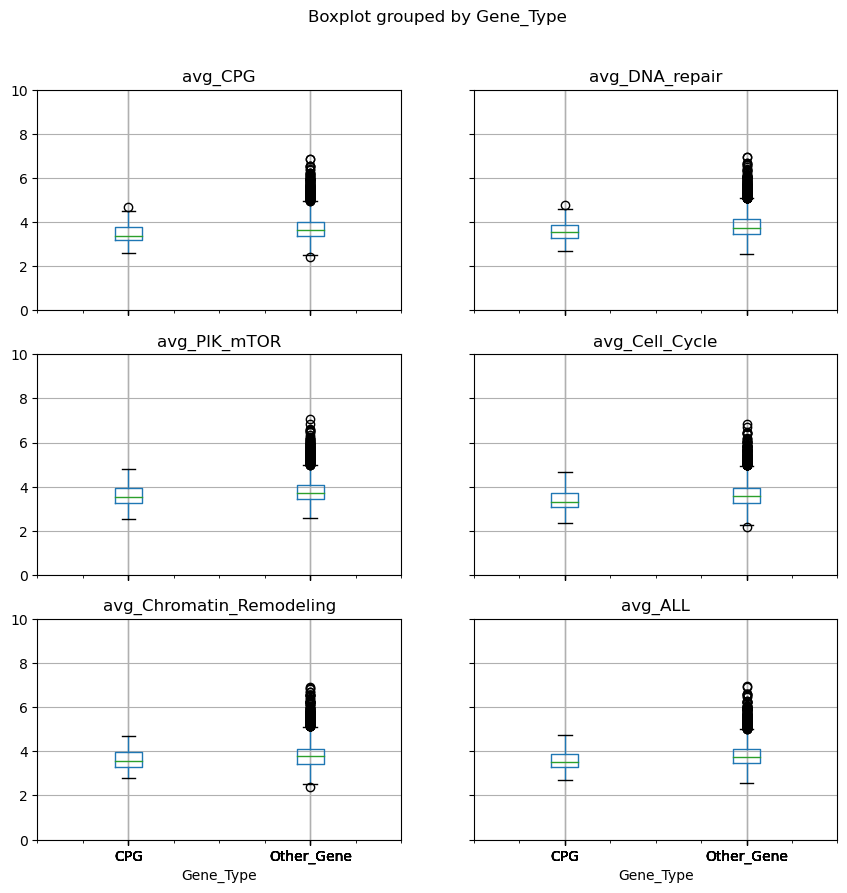

In [81]:
distances.boxplot(['avg_CPG', 'avg_DNA_repair', 'avg_PIK_mTOR', 'avg_Cell_Cycle', 'avg_Chromatin_Remodeling', 'avg_ALL'], by = 'Gene_Type', figsize = (10, 10))
# distances.boxplot(['avg_distance_all'], by = 'Gene_Type')
plt.ylim((0,10))
plt.savefig('/home/amaqueda/TFM/ML_project/PPI_interactions/output_HuRI/all.5.png')
plt.show()

## STATISTICS

In [12]:
for col in distances.columns[2:-1:2]:
    print(stats.kstest(distances[~distances[col].isnull()][col], 'norm'))
    print('\n')

KstestResult(statistic=0.9946994223362461, pvalue=0.0, statistic_location=2.604651162790698, statistic_sign=-1)


KstestResult(statistic=0.9956987124557765, pvalue=0.0, statistic_location=2.663865546218488, statistic_sign=-1)


KstestResult(statistic=0.996011918111735, pvalue=0.0, statistic_location=2.7359154929577465, statistic_sign=-1)


KstestResult(statistic=0.9918469209462684, pvalue=0.0, statistic_location=2.4521739130434783, statistic_sign=-1)


KstestResult(statistic=0.9950170093666816, pvalue=0.0, statistic_location=2.6153846153846154, statistic_sign=-1)


KstestResult(statistic=0.9958956322995546, pvalue=0.0, statistic_location=2.689521345407503, statistic_sign=-1)




In [13]:
for col in distances.columns[2:-1:2]:
    print(stats.kstest(distances[~distances[col].isnull() & (distances['Gene_Type'] == 'CPG')][col], 'norm'))
    print(stats.kstest(distances[~distances[col].isnull() & (distances['Gene_Type'] == 'Other_Gene')][col], 'norm'))
    print ('\n')

KstestResult(statistic=0.9949196593623266, pvalue=2.2972349967500313e-296, statistic_location=2.5703125, statistic_sign=-1)
KstestResult(statistic=0.9947801590251419, pvalue=0.0, statistic_location=2.604651162790698, statistic_sign=-1)


KstestResult(statistic=0.9963472128229435, pvalue=7.578332765e-315, statistic_location=2.682584269662921, statistic_sign=-1)
KstestResult(statistic=0.9956936863806546, pvalue=0.0, statistic_location=2.663865546218488, statistic_sign=-1)


KstestResult(statistic=0.9945482223649673, pvalue=2.0627625676667568e-292, statistic_location=2.545774647887324, statistic_sign=-1)
KstestResult(statistic=0.996090644370582, pvalue=0.0, statistic_location=2.7359154929577465, statistic_sign=-1)


KstestResult(statistic=0.9901846713713547, pvalue=1.8061548566711918e-259, statistic_location=2.333333333333333, statistic_sign=-1)
KstestResult(statistic=0.9920621458811912, pvalue=0.0, statistic_location=2.5130434782608697, statistic_sign=-1)


KstestResult(statistic=0.99750

In [14]:
for col in distances.columns[2:-1:2]:
    print(col)
    print(stats.mannwhitneyu(x = distances[~distances[col].isnull() & (distances['Gene_Type'] == 'CPG')][col],
                             y = distances[~distances[col].isnull() & (distances['Gene_Type'] == 'Other_Gene')][col]))
    print('\n')

avg_CPG
MannwhitneyuResult(statistic=520023.5, pvalue=2.7033129828704007e-08)


avg_DNA_repair
MannwhitneyuResult(statistic=552326.5, pvalue=2.7334548665821015e-06)


avg_PIK_mTOR
MannwhitneyuResult(statistic=564570.0, pvalue=1.2989766645778774e-05)


avg_Cell_Cycle
MannwhitneyuResult(statistic=530573.5, pvalue=1.3231251018964692e-07)


avg_Chromatin_Remodeling
MannwhitneyuResult(statistic=593292.5, pvalue=0.0003332010408212873)


avg_ALL
MannwhitneyuResult(statistic=557495.5, pvalue=5.34613262971581e-06)


